# Purification of general mixed entangled state:

We have defined the general mixed entangled state as:
$$\rho_{\text{mixed}} = F|\phi_+\rangle \langle\phi_+| + A|\phi_-\rangle \langle \phi_-| + B|\psi_+\rangle \langle \psi_+| + C|\psi_-\rangle \langle \psi_-|$$


We will utilize the Pauli error noise model in Qiskit to prepare the initial mixed entangled state. First, let's determine the values of $F, A, B$, and $C$ by considering the Pauli noise model.

In [1]:
import numpy as np
from IPython.display import Markdown

# Define the vectors |0> and |1>
H = np.array([[1], [0]])  # |0>
V = np.array([[0], [1]])  # |1>

# Define the Bell states
phi_p = 1/np.sqrt(2) * (np.kron(H, H) + np.kron(V, V))
si_m = 1/np.sqrt(2) * (np.kron(H, V) - np.kron(V, H))
si_p = 1/np.sqrt(2) * (np.kron(H, V) + np.kron(V, H))
phi_m = 1/np.sqrt(2) * (np.kron(H, H) - np.kron(V, V))

# Define the input state
input_state = np.dot(phi_p, phi_p.T)

#Set the probabilities of each Pauli error: 
gi = 0.6
gx = 0.3
gz = 0.1
# Pauli error
pi = np.sqrt(gi)
px = np.sqrt(gx)
pz = np.sqrt(gz)
e = []
e.append(pi * np.array([[1, 0], [0, 1]]))
e.append(px * np.array([[0, 1], [1, 0]]))
e.append(pz * np.array([[1, 0], [0, -1]]))

#Both qubits are passing through Puali error channle, so we have 9 Kraus operators:
E = []
for j in range(3):
    for ii in range(3):
        E.append(np.kron(e[j], e[ii]))

#The damped entangled state after Puali error:
rer = np.zeros((4, 4))
for kk in range(9):
    rer += np.dot(np.dot(E[kk], input_state), E[kk].conj().T)

print("\\rho_{general}=")
print(rer)
#Finding the probabilities of each Bell states:
F = np.trace(np.dot(phi_p.conj().T, np.dot(rer, phi_p)))
A = np.trace(np.dot(phi_m.conj().T, np.dot(rer, phi_m)))
B = np.trace(np.dot(si_p.conj().T, np.dot(rer, si_p)))
C = np.trace(np.dot(si_m.conj().T, np.dot(rer, si_m)))
print("F=",F)
print("A=",A)
print("B=",B)
print("C=",C)

\rho_{general}=
[[0.29 0.   0.   0.17]
 [0.   0.21 0.15 0.  ]
 [0.   0.15 0.21 0.  ]
 [0.17 0.   0.   0.29]]
F= 0.45999999999999996
A= 0.11999999999999998
B= 0.35999999999999976
C= 0.05999999999999992


Based on the mathematical calculations detailed in the paper, employing the designed general purification circuit yields the following maximally entangled states with their respective probabilities:

Obtaining $\phi_+$ with probability F,

Obtaining $\psi_+$ with probability A,

Obtaining $\phi_-$ with probability B, and

Obtaining $\psi_-$ with probability C.

# Qiskit Simulation

We will use the same error probabilities $gi, gx, gz$ in Qiskit simulation and compare the obtaining probabilities with the above probabilities.

C:\Users\Sajede Harraz\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


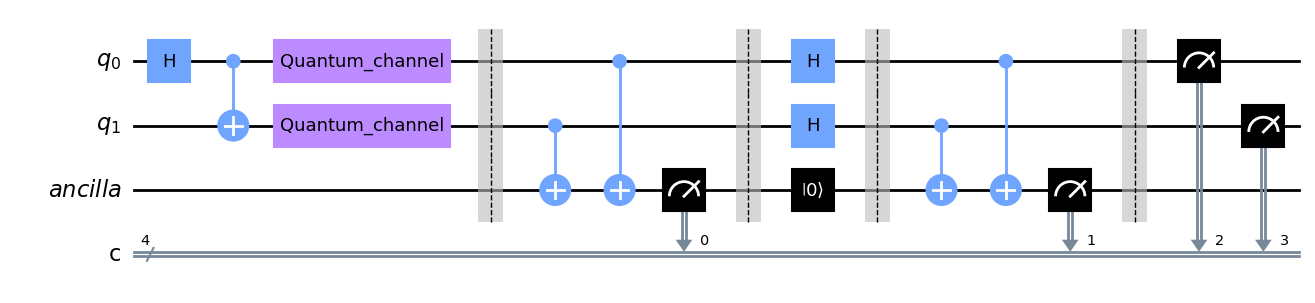

In [2]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, Aer,transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_city,  plot_histogram
from qiskit.providers.aer.noise import amplitude_damping_error, pauli_error, depolarizing_error, NoiseModel, phase_damping_error
from qiskit.quantum_info import DensityMatrix, partial_trace, Pauli
from qiskit_aer import AerSimulator
from qiskit.providers.aer import QasmSimulator
import matplotlib.pyplot as plt
import numpy as np
import math
q = QuantumRegister(2, 'q')

c = ClassicalRegister(4, 'c')
anc = QuantumRegister(1, 'ancilla') 
qc = QuantumCircuit(q,c,anc)
#####
qc.h(0)
qc.cx(0, 1)

pi = Pauli('I')
px = Pauli('X')
py = Pauli('Y')
pz = Pauli('Z')

noise_ops = [(pi, gi),(px, gx), (py, 0), (pz, gz)]
error = pauli_error(noise_ops)


qc.append(error, [0])
qc.append(error, [1])

qc.barrier()
qc.cx(1, 2)
qc.cx(0, 2)
qc.measure([2],c[0])

#qc.barrier()
qc.barrier()
qc.reset(2)
qc.h(0)
qc.h(1)
#####

qc.barrier()
qc.cx(1, 2)
qc.cx(0, 2)
qc.measure([2],c[1])
qc.barrier()
qc.measure([0,1],[2,3])
#####
qc.draw('mpl')

In [3]:
qc=qc.reverse_bits ()
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'0000': 23500, '1000': 17852, '1101': 2996, '0011': 22838, '1110': 2964, '0101': 5933, '1011': 17884, '0110': 6033}


<center>Obtaining maximally entangled state: $\phi_+$</center>

Qiskit Probability= 0.46338
Mathematical Probability= 0.45999999999999996


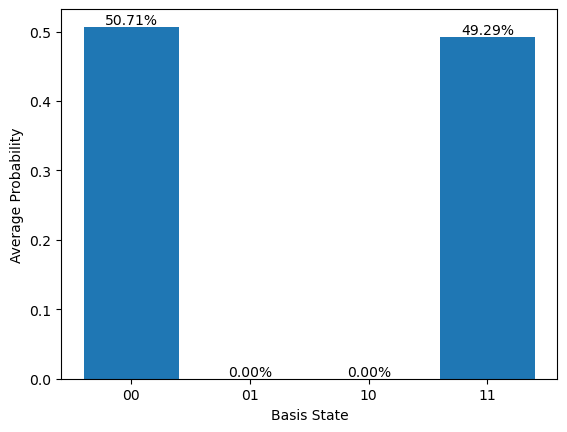

In [4]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:
        if (jj[0]=='0' and jj[1]=='0' ): #obtaining phi+
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[2:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]
        
        
# Define the text to be centered
text = "Obtaining maximally entangled state: $\phi_+$"
# Display the centered text using Markdown formatting
display(Markdown(f"<center>{text}</center>"))        

print('Qiskit Probability=',success/total)
print('Mathematical Probability=',F)

# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state
# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()

<center>Obtaining maximally entangled state: $\psi_+$</center>

Qiskit Probability= 0.11966
Mathematical Probability= 0.11999999999999998


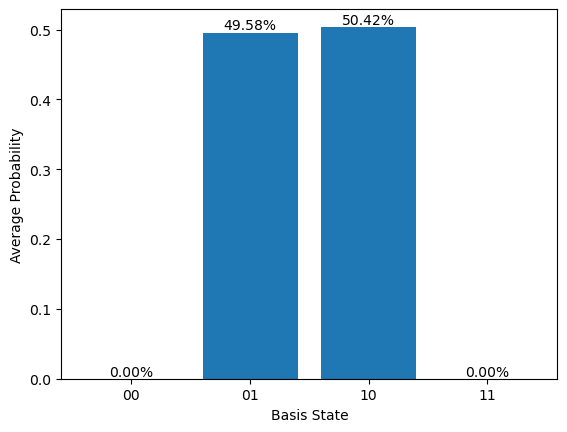

In [5]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:        
        if (jj[0]=='0' and jj[1]=='1' ): #obtaining psi+
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[2:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]
        
        
# Define the text to be centered
text = "Obtaining maximally entangled state: $\psi_+$"
# Display the centered text using Markdown formatting with bolding
display(Markdown(f"<center>{text}</center>"))    

print('Qiskit Probability=',success/total)
print('Mathematical Probability=',A)

# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state
# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()

<center>Obtaining maximally entangled state: $\phi_-$</center>

Qiskit Probability= 0.35736
Mathematical Probability= 0.35999999999999976


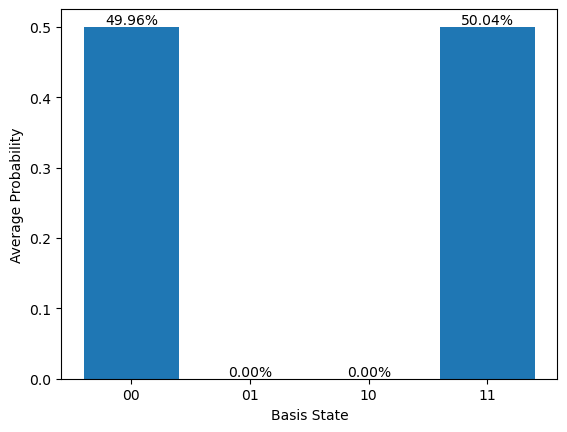

In [6]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:        
        if (jj[0]=='1' and jj[1]=='0' ): #obtaining phi-
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[2:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]
        
        
# Define the text to be centered
text = "Obtaining maximally entangled state: $\phi_-$"
# Display the centered text using Markdown formatting
display(Markdown(f"<center>{text}</center>"))        

print('Qiskit Probability=',success/total)
print('Mathematical Probability=',B)

# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state
# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()

<center>Obtaining maximally entangled state: $\psi_-$</center>

Qiskit Probability= 0.0596
Mathematical Probability= 0.05999999999999992


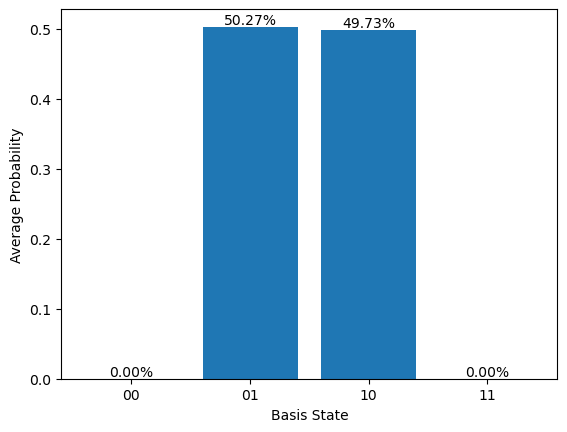

In [7]:
success, fail = 0, 0
Bell_states = {}
Bell_new= {}
for jj in counts:        
        if (jj[0]=='1' and jj[1]=='1' ): #obtaining psi-
            success += counts[jj]
            Bell_state = jj
            if Bell_state in Bell_states:
                Bell_states[Bell_state] += counts[jj]
            else:
                Bell_states[Bell_state] = counts[jj]
        else:
            fail += counts[jj]
            
total = success + fail

# Extract the last character from each Bell state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[2:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]
        
        
# Define the text to be centered
text = "Obtaining maximally entangled state: $\psi_-$"
# Display the centered text using Markdown formatting
display(Markdown(f"<center>{text}</center>"))        

print('Qiskit Probability=',success/total)
print('Mathematical Probability=',C)

# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states] # Normalized state
# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()